[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MaxMitre/ML-AI-for-the-Working-Analyst/blob/main/Semana9/Deteccion_anomalias_LSTM.ipynb)

## Detección de fallas por anomalías

En este notebook, usaremos una red neuronal de tipo autoencoder para identificar anomalías de la lectura de sensores en ciertos componentes ("Bearings", conocidos como rodamientos, cojinetes, etc.). El objetivo es tratar de predecir fallas en dichos componentes (los Bearings) antes de que estas sucedan. Los datos a utilizar son lecturas de sensores de la base de datos de acústica y vibraciones, de la NASA (Acoustics and Vibration Database - [Aquí](https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/)). Cada dato consta de señales de un segundo tomadas en 4 Bearings, en intervalos de 10 minutos. Cada archivo contiene datos de 20,480 puntos de sensores que se obtuvieron en la lectura de sensores de los Bearings en muestras de 20 kHz. Todos los datos de un archivo se concentrarán en una fila de nuestro DataFrame al tomar el promedio de los valores absolutos de los datos.

Esta red neuronal utilizará neuronas Long Short-Term Memory (LSTM), componentes de una Red Neuronal Recurrente (RNN por sus siglas en inglés) utilizadas por medio de Keras/Tensorflow.

In [ ]:
# import libraries
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import joblib
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import seed
#from tensorflow import set_random_seed
import tensorflow as tf
#tf.logging.set_verbosity(tf.logging.ERROR)


from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers

In [ ]:
# set random seed
seed(10)
tf.random.set_seed(10)

# Carga de datos y preprocesamiento

Un supuesto es que la degradación de los Bearings ocurre gradualmente en el tiempo, por lo que utilizamos los datos tomados cada 10 minutos. Cada 10 minutos, los datos se agregan utilizando el valor absoluto medio de las vibraciones registradas en 20,480 puntos en cada archivo. Juntamos todo en un solo DataFrame.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# carga, promediado y combinado de muestras de los sensores
data_dir = '/content/drive/MyDrive/Curso-WorkingAnalyst/semana9/bearing_data'
merged_data = pd.DataFrame()

for filename in os.listdir(data_dir):
    dataset = pd.read_csv(os.path.join(data_dir, filename), sep='\t')
    dataset_mean_abs = np.array(dataset.abs().mean())
    dataset_mean_abs = pd.DataFrame(dataset_mean_abs.reshape(1,4))
    dataset_mean_abs.index = [filename]
    merged_data = merged_data.append(dataset_mean_abs)
    
merged_data.columns = ['Bearing 1', 'Bearing 2', 'Bearing 3', 'Bearing 4']

In [ ]:
merged_data

,Bearing 1,Bearing 2,Bearing 3,Bearing 4
2004.02.18.16.22.39,0.093141,0.088548,0.090853,0.053908
2004.02.18.15.52.39,0.093979,0.087966,0.090682,0.054724
2004.02.18.16.12.39,0.093622,0.090123,0.091606,0.054020
2004.02.18.16.02.39,0.092087,0.088622,0.089065,0.054204
2004.02.18.16.42.39,0.097414,0.091543,0.092235,0.054945
...,...,...,...,...
2004.02.18.14.32.39,0.112502,0.085334,0.086622,0.054250
2004.02.18.15.02.39,0.105560,0.085828,0.087953,0.053688
2004.02.18.15.32.39,0.095559,0.086469,0.088816,0.055151
2004.02.18.15.42.39,0.094821,0.089184,0.090852,0.054423


In [ ]:
# tranforma los indices de los datos a datetime y los ordena cronológicamente
merged_data.index = pd.to_datetime(merged_data.index, format='%Y.%m.%d.%H.%M.%S')
merged_data = merged_data.sort_index()
# Guardamos temporalmente los datos
merged_data.to_csv('Averaged_BearingTest_Dataset.csv')
print("Forma del Dataset:", merged_data.shape)
merged_data.head()

Forma del Dataset: (982, 4)


,Bearing 1,Bearing 2,Bearing 3,Bearing 4
2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443
2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081
2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118
2004-02-12 11:22:39,0.061665,0.073279,0.084879,0.044172
2004-02-12 11:32:39,0.061944,0.074593,0.082626,0.044659


# Datos de entrenamiento/prueba

Para analizar esto, tomamos los primeros datos para el entrenamiento (en donde deberían funcio9nar normalmente las piezas) y los datos de prueba son los datos que llevarán a alguna falla (avanzando en el tiempo).

In [ ]:
train = merged_data['2004-02-12 10:52:39': '2004-02-15 12:52:39']
test = merged_data['2004-02-15 12:52:39':]
print("Forma de los datos de entrenamiento:", train.shape)
print("Forma de los datos de prueba:", test.shape)

Forma de los datos de entrenamiento: (445, 4)
Forma de los datos de prueba: (538, 4)


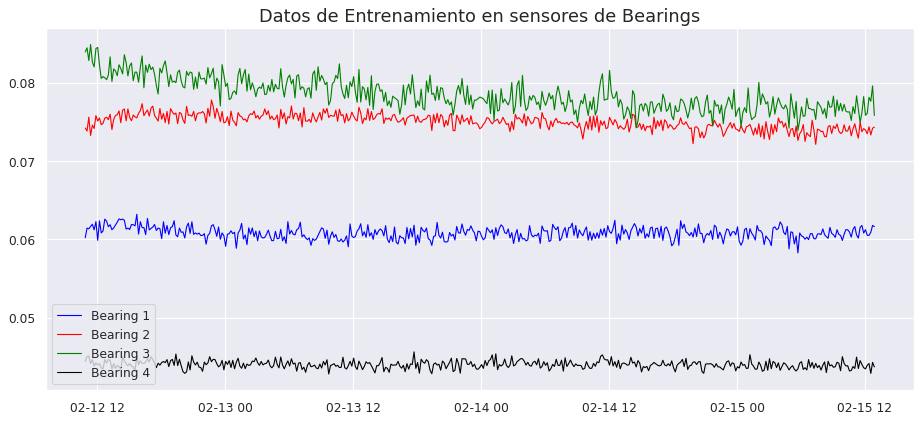

In [ ]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(train['Bearing 1'], label='Bearing 1', color='blue', animated = True, linewidth=1)
ax.plot(train['Bearing 2'], label='Bearing 2', color='red', animated = True, linewidth=1)
ax.plot(train['Bearing 3'], label='Bearing 3', color='green', animated = True, linewidth=1)
ax.plot(train['Bearing 4'], label='Bearing 4', color='black', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Datos de Entrenamiento en sensores de Bearings', fontsize=16)
plt.show()

Vamos a tomar otra perspectiva para los datos, transformaremos las señales tomadas respecto al tiempo a tomarlas respecto a la frecuencia utilizando una transformada de Fourier discreta.

In [ ]:
# transformando datos del dominio en el tiempo a dominio en la frecuencia usando la transformada de Fourier rápida
train_fft = np.fft.fft(train)
test_fft = np.fft.fft(test)

In [ ]:
train_fft[1]

array([ 0.26483837+0.j        , -0.023002  -0.02876268j,
        0.0269874 +0.j        , -0.023002  +0.02876268j])

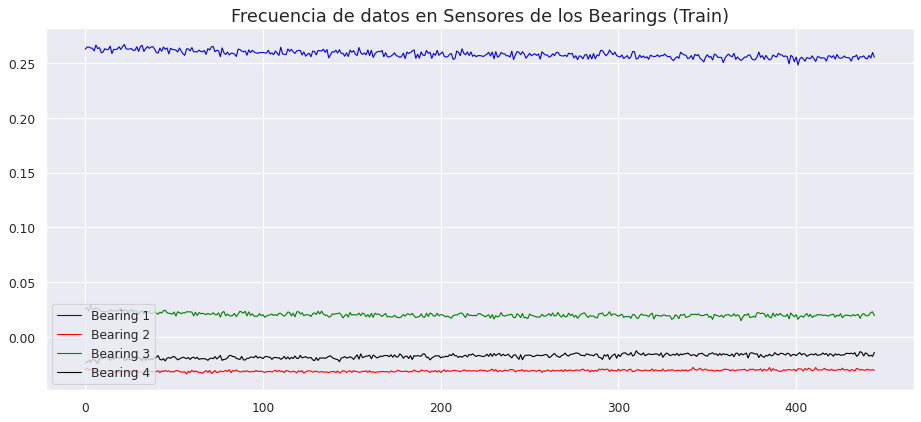

In [ ]:
# Frecuencias de las señales de sensores "sanos"
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(train_fft[:,0].real, label='Bearing 1', color='blue', animated = True, linewidth=1)
ax.plot(train_fft[:,1].imag, label='Bearing 2', color='red', animated = True, linewidth=1)
ax.plot(train_fft[:,2].real, label='Bearing 3', color='green', animated = True, linewidth=1)
ax.plot(train_fft[:,3].real, label='Bearing 4', color='black', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Frecuencia de datos en Sensores de los Bearings (Train)', fontsize=16)
plt.show()

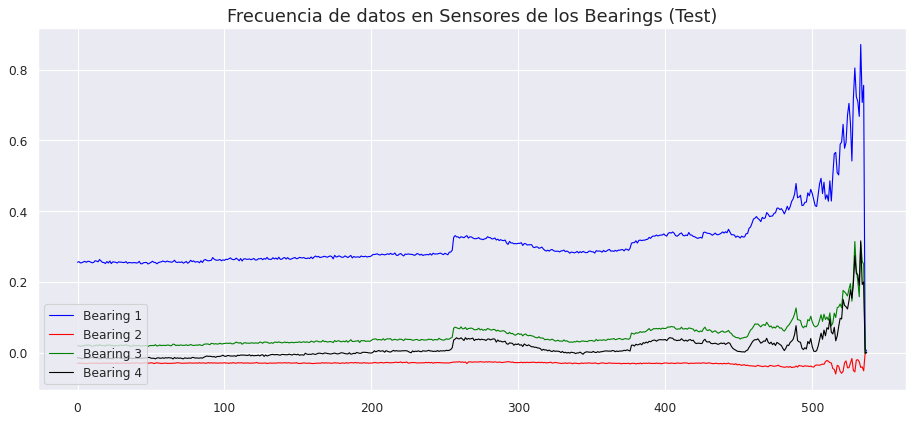

In [ ]:
# frecuencias del degradado de la señal de los datos
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(test_fft[:,0].real, label='Bearing 1', color='blue', animated = True, linewidth=1)
ax.plot(test_fft[:,1].imag, label='Bearing 2', color='red', animated = True, linewidth=1)
ax.plot(test_fft[:,2].real, label='Bearing 3', color='green', animated = True, linewidth=1)
ax.plot(test_fft[:,3].real, label='Bearing 4', color='black', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Frecuencia de datos en Sensores de los Bearings (Test)', fontsize=16)
plt.show()

In [ ]:
# Estandarización de los datos
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train)
X_test = scaler.transform(test)
scaler_filename = "scaler_data"
# Guardar los datos momentaneamente
joblib.dump(scaler, scaler_filename)

['scaler_data']

In [ ]:
X_train

array([[0.39518051, 0.36851684, 0.91295856, 0.56833449],
       [0.64304579, 0.30094449, 0.96148238, 0.79465028],
       [0.62379364, 0.61266227, 0.81348964, 0.80775623],
       ...,
       [0.53419516, 0.21178246, 0.33869465, 0.02647161],
       [0.71083045, 0.36463536, 0.51749078, 0.52396122],
       [0.68310894, 0.38704446, 0.17330254, 0.32004848]])

In [ ]:
# Reshape a los datos de entrada (inputs) para la capa LSTM [samples, timesteps, features]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print("Training data shape:", X_train.shape)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print("Test data shape:", X_test.shape)

Training data shape: (445, 1, 4)
Test data shape: (538, 1, 4)


In [ ]:
# Definimos la red neuronal con autoencoder
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(16, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model

In [ ]:
# Creamos el modelo de tipo autoencoder
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 4)]            0         
                                                                 
 lstm (LSTM)                 (None, 1, 16)             1344      
                                                                 
 lstm_1 (LSTM)               (None, 4)                 336       
                                                                 
 repeat_vector (RepeatVector  (None, 1, 4)             0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, 1, 4)              144       
                                                                 
 lstm_3 (LSTM)               (None, 1, 16)             1344      
                                                             

In [ ]:
# Ajustamos el modelo a nuestros datos
nb_epochs = 100
batch_size = 10
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.05).history

Epoch 1/100
43/43 [==============================] - 7s 22ms/step - loss: 0.4454 - val_loss: 0.3190
Epoch 2/100
43/43 [==============================] - 0s 6ms/step - loss: 0.3812 - val_loss: 0.2455
Epoch 3/100
43/43 [==============================] - 0s 6ms/step - loss: 0.2909 - val_loss: 0.1621
Epoch 4/100
43/43 [==============================] - 0s 7ms/step - loss: 0.1621 - val_loss: 0.1684
Epoch 5/100
43/43 [==============================] - 0s 6ms/step - loss: 0.1152 - val_loss: 0.1404
Epoch 6/100
43/43 [==============================] - 0s 7ms/step - loss: 0.1073 - val_loss: 0.1225
Epoch 7/100
43/43 [==============================] - 0s 6ms/step - loss: 0.1035 - val_loss: 0.1146
Epoch 8/100
43/43 [==============================] - 0s 6ms/step - loss: 0.1019 - val_loss: 0.1138
Epoch 9/100
43/43 [==============================] - 0s 6ms/step - loss: 0.1013 - val_loss: 0.1151
Epoch 10/100
43/43 [==============================] - 0s 6ms/step - loss: 0.1011 - val_loss: 0.1132
Epoch 11

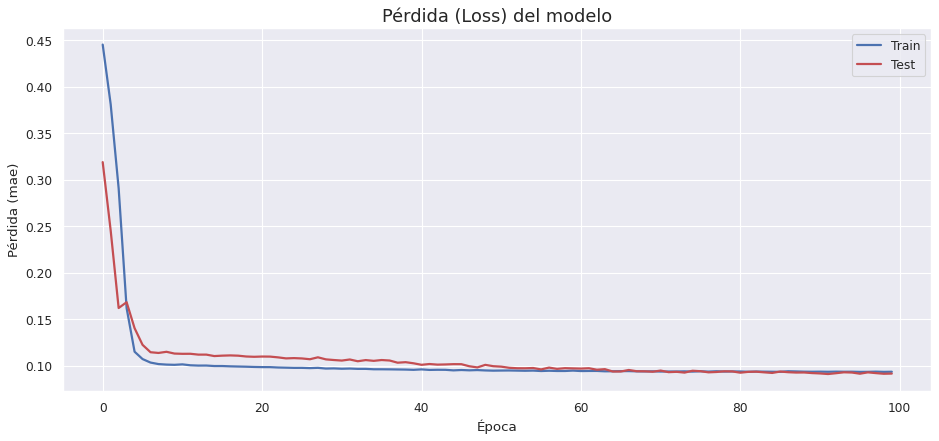

In [ ]:
# Gráfico de la perdida respecto a las épocas de entrenamiento
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Test', linewidth=2)
ax.set_title('Pérdida (Loss) del modelo', fontsize=16)
ax.set_ylabel('Pérdida (mae)')
ax.set_xlabel('Época')
ax.legend(loc='upper right')
plt.show()

In [ ]:
history['loss'][-1]

0.09362390637397766

# Distribución de la función de pérdida

Ploteando la distribución de las perdidas en el conjunto de entrenamiento. uno puede identificar un valor límite (treshold) para identificar anomalías. Con esto podemos escoger un límite tal que etiquetemos algún dato como falla de manera significativa.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 0.5)

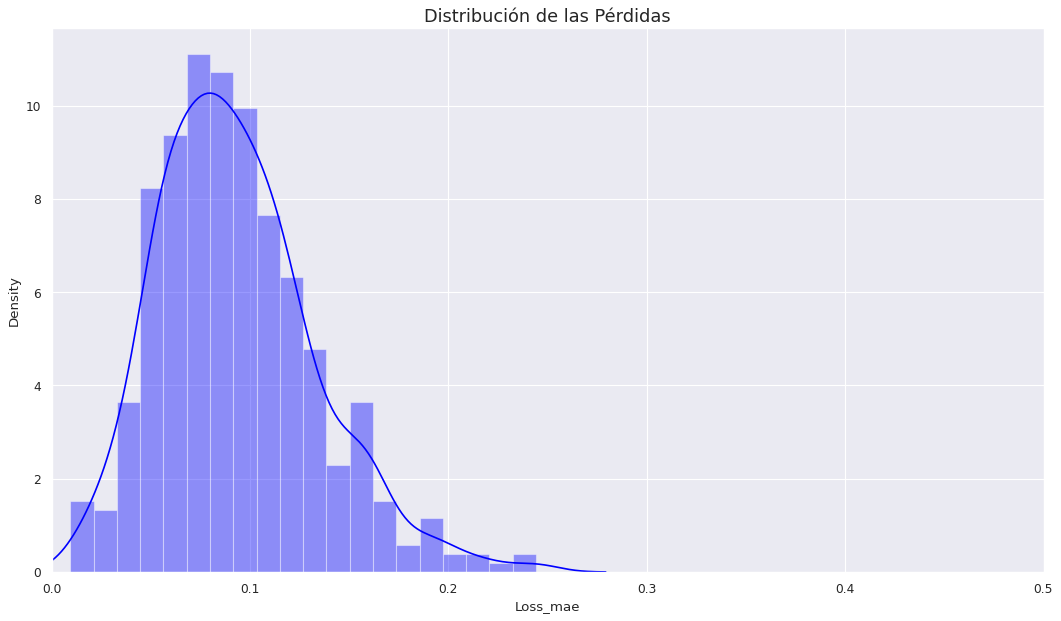

In [ ]:
# Ploteo de la distribución de las pérdidas en el conjunto de entrenamiento (train)
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=train.columns)
X_pred.index = train.index

scored = pd.DataFrame(index=train.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Distribución de las Pérdidas', fontsize=16)
sns.distplot(scored['Loss_mae'], bins = 20, kde= True, color = 'blue');
plt.xlim([0.0,.5])

Viendo la distribución mostrada arriba, utilicemos como límite el valor 0.275 para clasificar algo como anomalía. Luego calculamos la pérdida en el conjunto de test para clasificar algo como anomalía.

In [ ]:
# Calculo de la pérdida en el conjunto de test
X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=test.columns)
X_pred.index = test.index

scored = pd.DataFrame(index=test.index)
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis = 1)
scored['Threshold'] = 0.275
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.head()

,Loss_mae,Threshold,Anomaly
2004-02-15 12:52:39,0.094935,0.275,False
2004-02-15 13:02:39,0.171799,0.275,False
2004-02-15 13:12:39,0.067531,0.275,False
2004-02-15 13:22:39,0.053269,0.275,False
2004-02-15 13:32:39,0.039348,0.275,False


In [ ]:
scored[80:100]

In [ ]:
# Calculamos la misma métrica para el conjunto de test
# y combinamos todos los datos para plotearlos juntos
X_pred_train = model.predict(X_train)
X_pred_train = X_pred_train.reshape(X_pred_train.shape[0], X_pred_train.shape[2])
X_pred_train = pd.DataFrame(X_pred_train, columns=train.columns)
X_pred_train.index = train.index

scored_train = pd.DataFrame(index=train.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-Xtrain), axis = 1)
scored_train['Threshold'] = 0.275
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored = pd.concat([scored_train, scored])

Having calculated the loss distribution and the anomaly threshold, we can visualize the model output in the time leading up to the bearing failure.

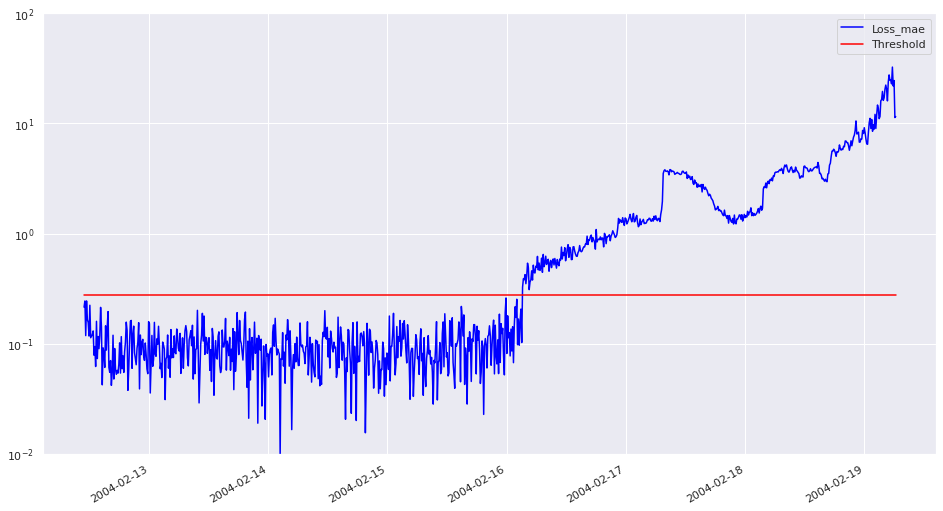

In [ ]:
# ploteamos la falla de los bearings en el tiempo
scored.plot(logy=True,  figsize=(16,9), ylim=[1e-2,1e2], color=['blue','red'])

Este análisis nos permite clasificar algo como una anomalía con mucha antelación antes de que realmente falle el componente (bearing).

Es importante escoger un buen Treshold para clasificar algo como anomalía, tratando de evitar bastantes falsos positivos bajo condiciones normales.

In [ ]:
# se puede guardar la información del modelo, incluyendo pesos, en formato h5
model.save("Cloud_model.h5")
print("Modelo guardado")

Modelo guardado


In [ ]:
# Cargar los pesos del modelo
model.load_weights('Cloud_model.h5')